# Subsampling the Paleoproterozoic d13C database
This notebook can be used to: 
- Load the Paleoproterozoic d13C and geochronology database
- Subsample the data using `stratmc.data.downsample`
- Plot the subsampled and original observations
- Produce Fig. S2 (subsampling methods)
- Compare the size of the original and subsampled data sets

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import pandas as pd
import seaborn as sns
import stratmc
import warnings


rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Avenir"]
rcParams.update({"text.usetex": False})

from scipy.stats import norm 
from tqdm.notebook import tqdm 

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data

In [2]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             proxy_sigma_default = 0.2, 
                                             combine_no_superposition = True) # set to true for subsampling (groups all samples from same stratigraphic height)

sample_df.head()

,section,Continent,Country,Unit,Member,Group,Supergroup/Association,Site,Section ID,height,...,Exclude?,Isotopic data references,Lithology,Sample description,Metamorphic Grade (and reference if different from isotopic reference),Depositional Environment,Turbiditic?\n(deep water units only),Depositional Environment Description (and reference),Notes,d13c_population_std
0,12B_Crne2014,Europe,Russia,Zaonega Formation,NaN,Karelia Group,Onega Basin,12B,NaN,0.46,...,False,Črne et al. 2014,NaN,NaN,Greenschist,"Lower ramp, slope, and deep basin",-,Deep-water shelf-slope-basin (Paiste et al. 2020),NaN,NaN
1,12B_Crne2014,Europe,Russia,Zaonega Formation,NaN,Karelia Group,Onega Basin,12B,NaN,0.58,...,False,Črne et al. 2014,NaN,NaN,Greenschist,"Lower ramp, slope, and deep basin",-,Deep-water shelf-slope-basin (Paiste et al. 2020),NaN,NaN
2,12B_Crne2014,Europe,Russia,Zaonega Formation,NaN,Karelia Group,Onega Basin,12B,NaN,0.70,...,False,Črne et al. 2014,NaN,NaN,Greenschist,"Lower ramp, slope, and deep basin",-,Deep-water shelf-slope-basin (Paiste et al. 2020),NaN,NaN
3,12B_Crne2014,Europe,Russia,Zaonega Formation,NaN,Karelia Group,Onega Basin,12B,NaN,111.85,...,False,Črne et al. 2014,NaN,NaN,Greenschist,"Lower ramp, slope, and deep basin",-,Deep-water shelf-slope-basin (Paiste et al. 2020),NaN,NaN
4,12B_Crne2014,Europe,Russia,Zaonega Formation,NaN,Karelia Group,Onega Basin,12B,NaN,111.98,...,False,Črne et al. 2014,NaN,NaN,Greenschist,"Lower ramp, slope, and deep basin",-,Deep-water shelf-slope-basin (Paiste et al. 2020),NaN,NaN


In [3]:
# group section names by priority level and compile list of section to be downsampled
priority_1_sections = section_metadata[(section_metadata['Inversion priority level']==1) & (~section_metadata['Included in composite section?'])]['section']
priority_2_sections = section_metadata[(section_metadata['Inversion priority level']==2) & (~section_metadata['Included in composite section?'])]['section']
priority_3_sections = section_metadata[(section_metadata['Inversion priority level']==3) & (~section_metadata['Included in composite section?'])]['section']
priority_4_sections = section_metadata[(section_metadata['Inversion priority level']==4) & (~section_metadata['Included in composite section?'])]['section']

downsample_sections = section_metadata[((section_metadata['Inversion priority level']==1) | (section_metadata['Inversion priority level']==2)) & (~section_metadata['Included in composite section?']) & (section_metadata['Downsample?'])]['section'].values
no_downsample_sections = section_metadata[((section_metadata['Inversion priority level']==1) | (section_metadata['Inversion priority level']==2)) & (~section_metadata['Included in composite section?']) & ~(section_metadata['Downsample?'].values.astype(bool))]['section'].values

include_sections = np.concatenate([priority_1_sections, priority_2_sections])

## Subsample the d13C data
To load the subsampled data set used in the Paleoproterozoic d13C inference, skip to [Load the subsampled data](#Load-the-subsampled-data).

In [73]:
# list of sections to subsample more liberally due to high sampling density/high-frequency d13C variance
oversampled_sections = ['ML1809', 
                 'UM (Umra-Dedkiya)', 
                 'Snowy Pass Supergroup Composite', 
                 'Kona Dolomite', 
                 'Hutuo Supergroup - Kong et al. (2011)', 
                 'Wyloo Group Composite']

# assign target minimum likelihood ratios to each section to be downsampled; defaults to 0.55 unless section is in oversampled_sections
min_likelihood_ratio_dict = {} 

for section in downsample_sections: 
    if section == 'Belcher Group Composite':
        min_likelihood_ratio_dict[section] = 0.15
        
    elif section in oversampled_sections: 
        min_likelihood_ratio_dict[section] = 0.4
        
    else: 
        min_likelihood_ratio_dict[section] = 0.55

sample_df_downsampled, solution_likelihoods, solution_corr_coef = stratmc.data.downsample(
                      sample_df, 
                      ages_df, 
                      sections = downsample_sections,
                      N = 50000, 
                      likelihood_ratio_min = min_likelihood_ratio_dict, 
                      proxy = 'd13c', 
                      keep = 'best', 
                      keep_seed = None, # only required for reproducibility if keep = 'random'
                      resample_with_lowest_n = True, 
                      flexible_n = True,
                      best_criteria = 'corr_coef') 
    
    
# save the downsampled data and solution statistics
# stratmc.data.save_object(sample_df_downsampled, 'data/downsampling/downsampled_sample_df')
# stratmc.data.save_object(solution_likelihoods, 'data/downsampling/downsampling_solution_likelihood')
# stratmc.data.save_object(solution_corr_coef, 'data/downsampling/downsampling_solution_corr_coef')
    

  0%|          | 0/72 [00:00<?, ?it/s]

Downsampling Sengoma Argillite Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Sengoma Argillite Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling LST12


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling LST12


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Silverton-Houtenbek composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Silverton-Houtenbek composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Tongwane-Duitschland composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Tongwane-Duitschland composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling BH1-Sacha


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling BH1-Sacha


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Farm Sandridge


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Farm Sandridge


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Farm Taabosfontain


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Farm Taabosfontain


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Postmasburg Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Postmasburg Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Mcheka


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Mcheka


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Hutuo Supergroup - Kong et al. (2011)


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Hutuo Supergroup - Kong et al. (2011)


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Liaohe Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Liaohe Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Southern Fanhe Basin


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Southern Fanhe Basin


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Babarmal


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Babarmal


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling BD (Umra-Jampa)


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling BD (Umra-Jampa)


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling GU (Matoon)


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling GU (Matoon)


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Iswal


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Iswal


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Jhamarkotra Mine


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Jhamarkotra Mine


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Negadia


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Negadia


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Paloda


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Paloda


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UM (Umra-Dedkiya)


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UM (Umra-Dedkiya)


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Umra


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Umra


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling TDH-01


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling TDH-01


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling TDH-26


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling TDH-26


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling DDH88BG5


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling DDH88BG5


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling FVD1A


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling FVD1A


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Turee Creek Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Turee Creek Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Wyloo Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Wyloo Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling PP-011


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling PP-011


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling QMW 83-1


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling QMW 83-1


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Karasjok Drill Core


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Karasjok Drill Core


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Hyypia Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Hyypia Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Kuusamo Schist Belt


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Kuusamo Schist Belt


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Kalkkimaa Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Kalkkimaa Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Louepalo Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Louepalo Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Lower Kivalo Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Lower Kivalo Group


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Rantamaa Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Rantamaa Quarry


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Kvenvik Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Kvenvik Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Storviknes Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Storviknes Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Imandra-Varzuga Greenstone Belt


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Imandra-Varzuga Greenstone Belt


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling 4699


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling 4699


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling 5177


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling 5177


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling OPHC


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling OPHC


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Pechenga Greenstone Belt Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Pechenga Greenstone Belt Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling KGB


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling KGB


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Belcher Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Belcher Group Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Denison Mine


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Denison Mine


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Quirke Lake


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Quirke Lake


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1801


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1801


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1803


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1803


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1804


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1804


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1805


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1805


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1807


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1807


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1808


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1808


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling ML1809


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling ML1809


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Seward and Pistolet Groups


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Seward and Pistolet Groups


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Albanel Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Albanel Formation


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UN-16-27


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UN-16-27


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UN-16-31


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UN-16-31


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UN-16-34


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UN-16-34


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UN-16-35


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UN-16-35


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling UN-16-6


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling UN-16-6


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling 18224


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling 18224


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling A-6


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling A-6


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling BM-1


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling BM-1


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Kona Dolomite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Kona Dolomite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Black Hills


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Black Hills


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Snowy Pass Supergroup Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Snowy Pass Supergroup Composite


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Snowy Pass Supergroup Composite - Sierra Madre


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Snowy Pass Supergroup Composite - Sierra Madre


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Minas Supergroup


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Minas Supergroup


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Uruguay - PVA338


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Uruguay - PVA338


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Uruguay - PVA358


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Uruguay - PVA358


  0%|          | 0/50000 [00:00<?, ?it/s]

Downsampling Uruguay - TPA207


  0%|          | 0/50000 [00:00<?, ?it/s]

Resampling Uruguay - TPA207


  0%|          | 0/50000 [00:00<?, ?it/s]

## Load the subsampled data

In [4]:
# load subsampled d13C data
sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')

# load summary statistics for selected subsampling solutions
solution_corr_coef = stratmc.data.load_object('data/downsampling/downsampling_solution_corr_coef')
solution_likelihoods = stratmc.data.load_object('data/downsampling/downsampling_solution_likelihood')



## Plot the subsampled data
Creates a figure illustrating the subsampled signal (in blue) compared to the original signal (in gray) for each section. The right panel is labeled with the likelihood ratio ($\ell$) and correlation coefficient ($r$) of the selected solution, along with the number of data points in the subsampled section ($n$). 

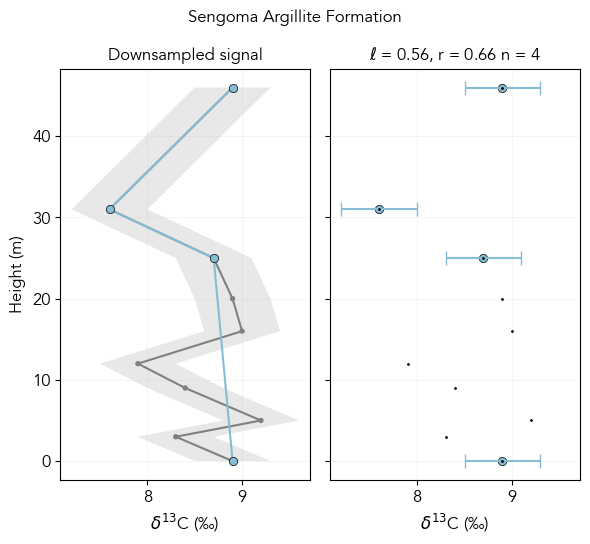

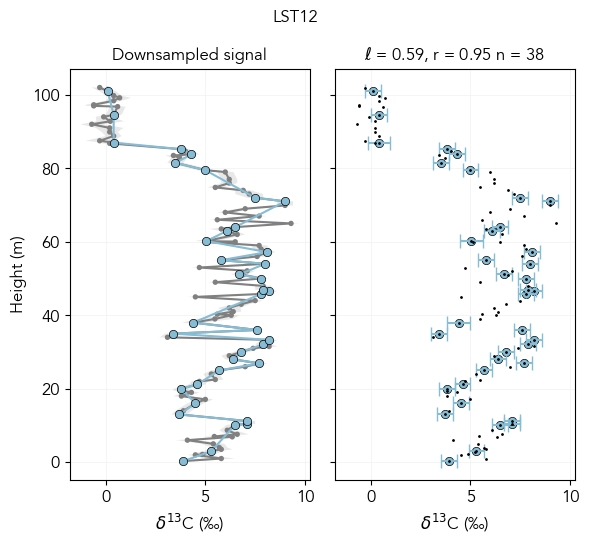

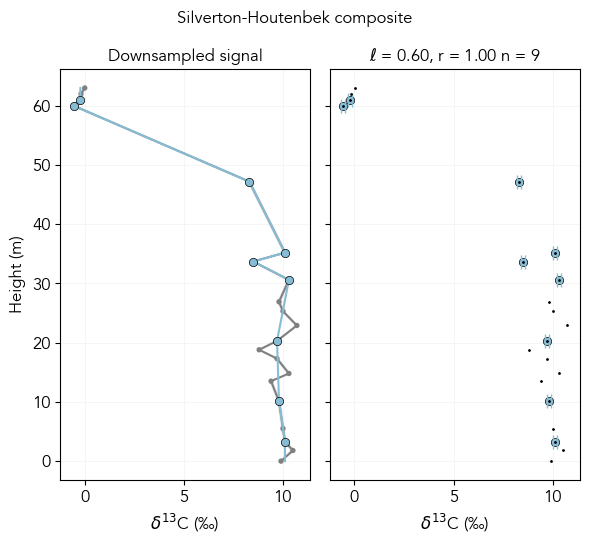

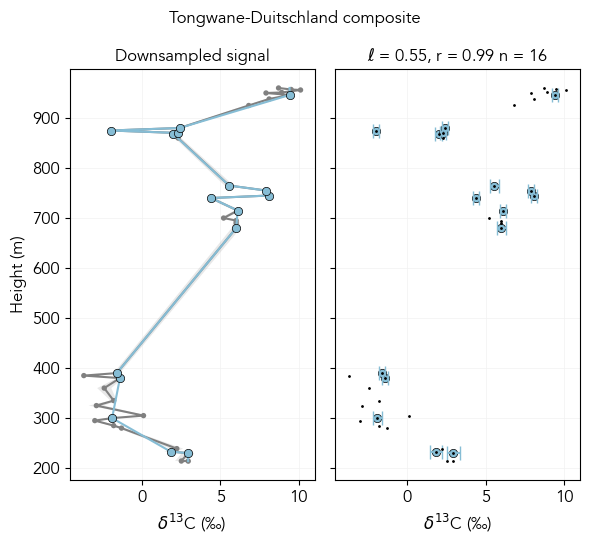

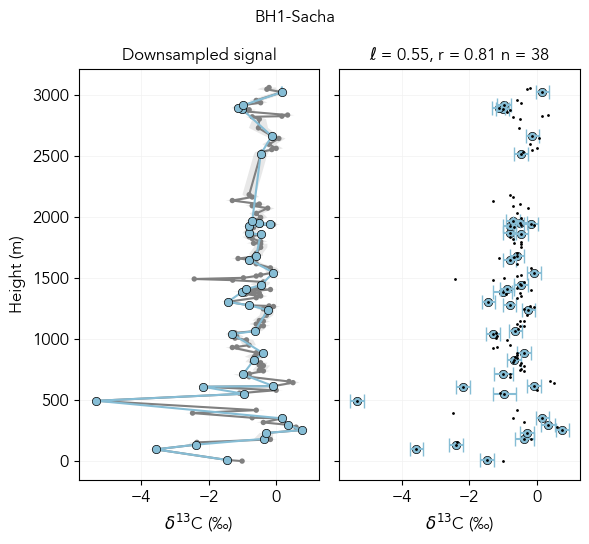

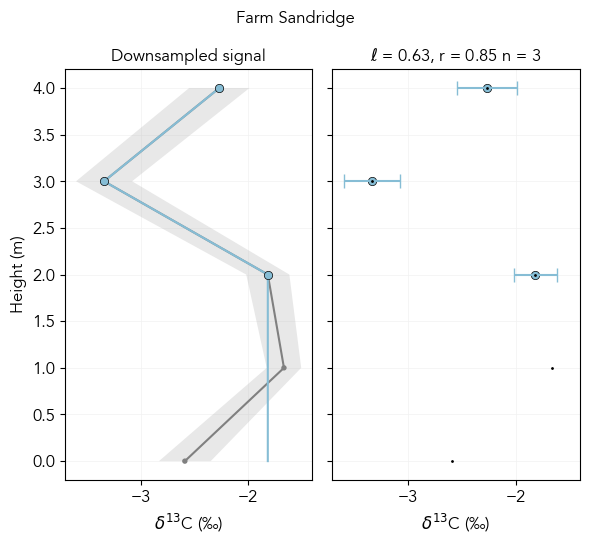

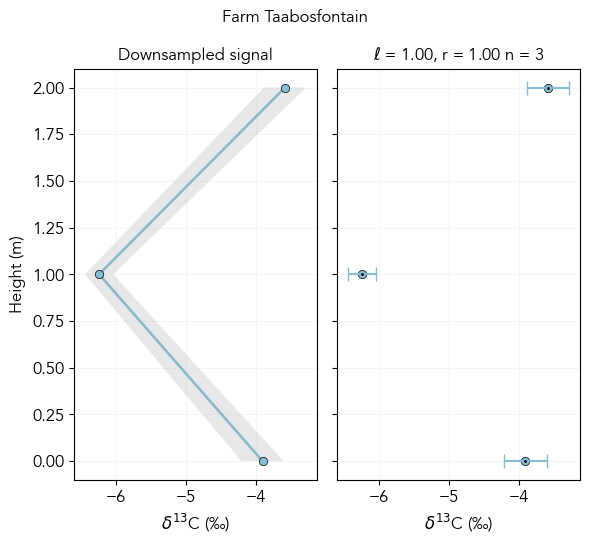

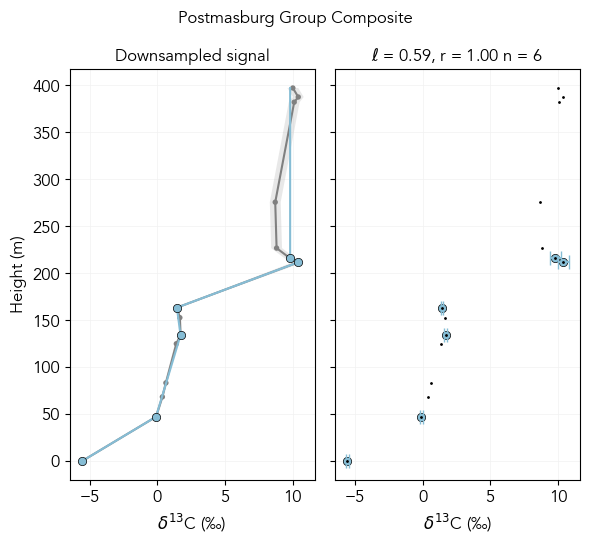

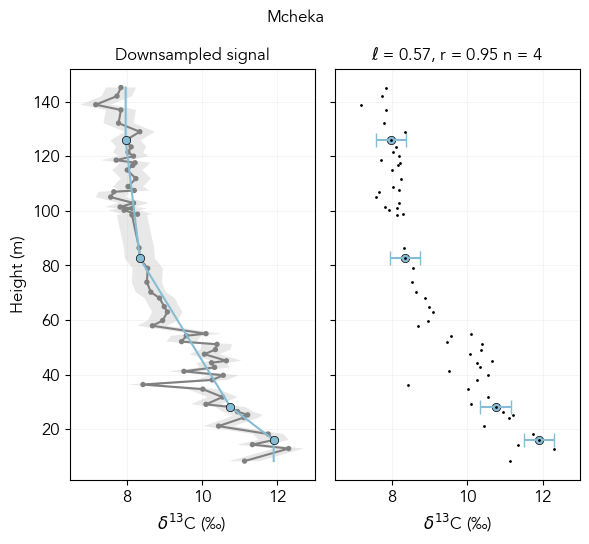

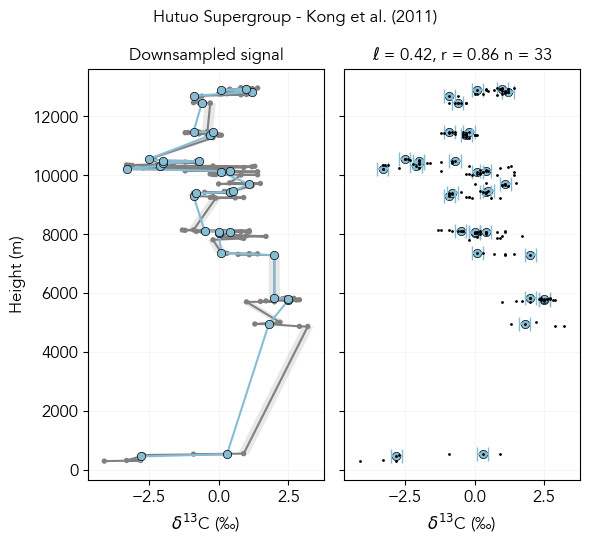

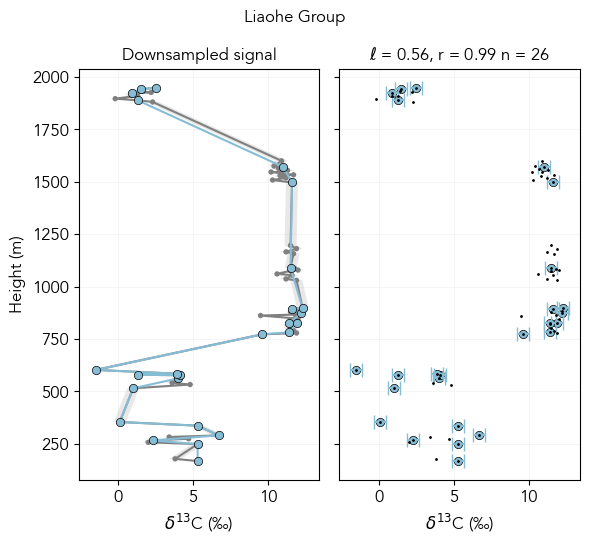

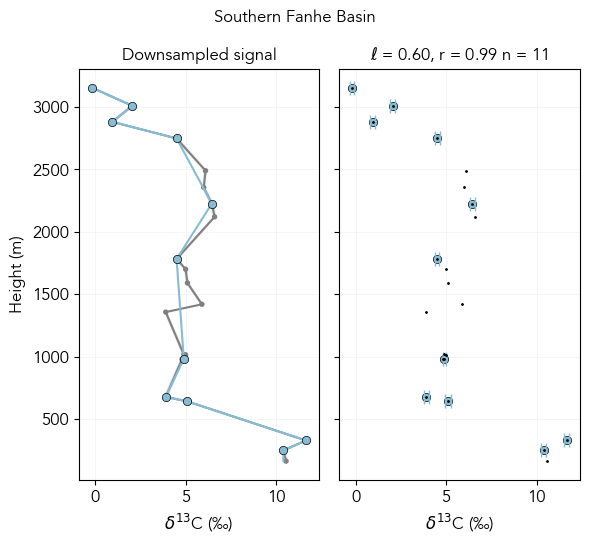

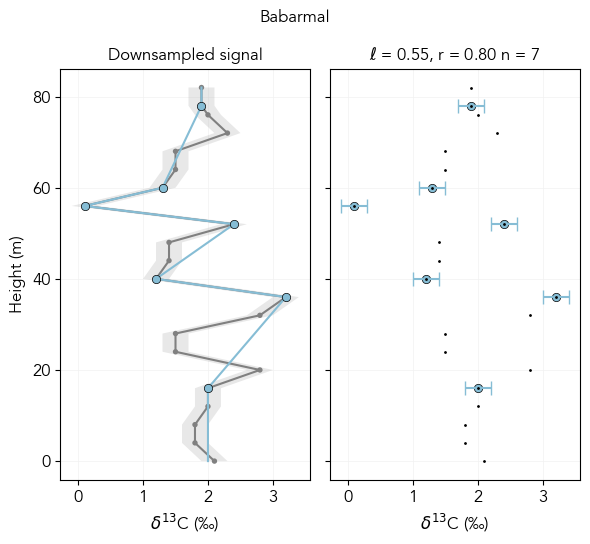

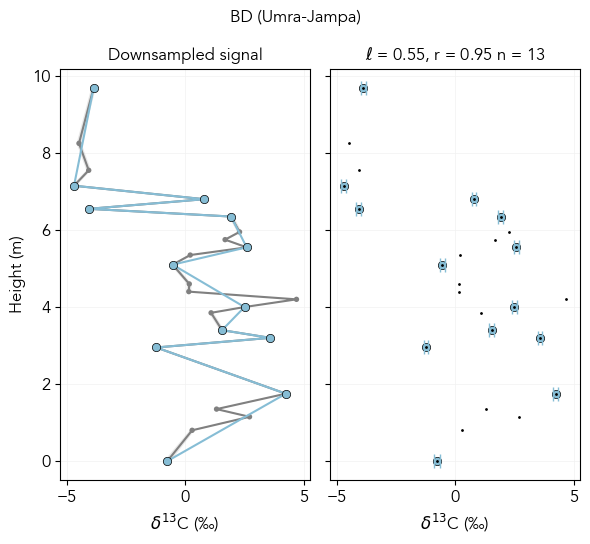

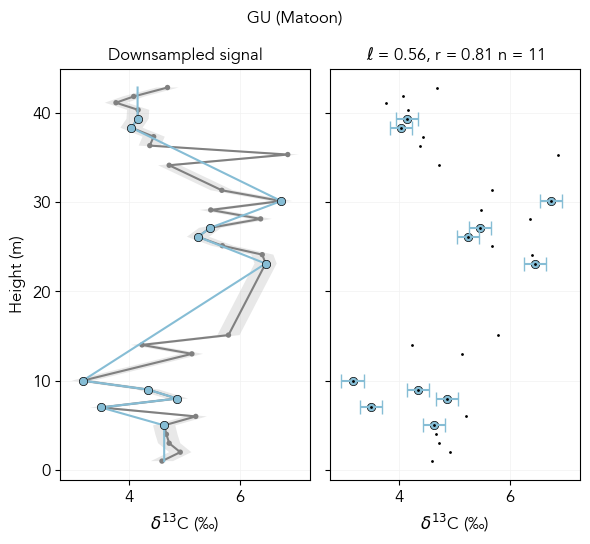

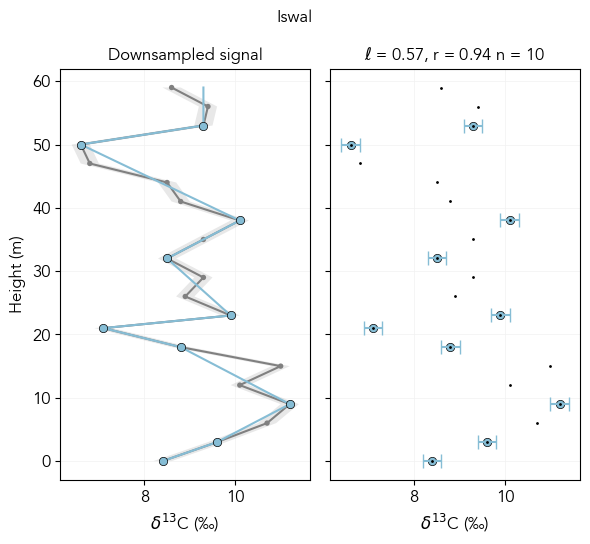

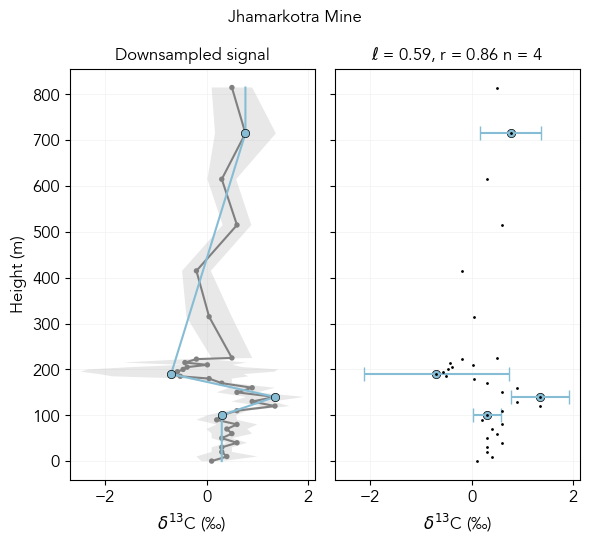

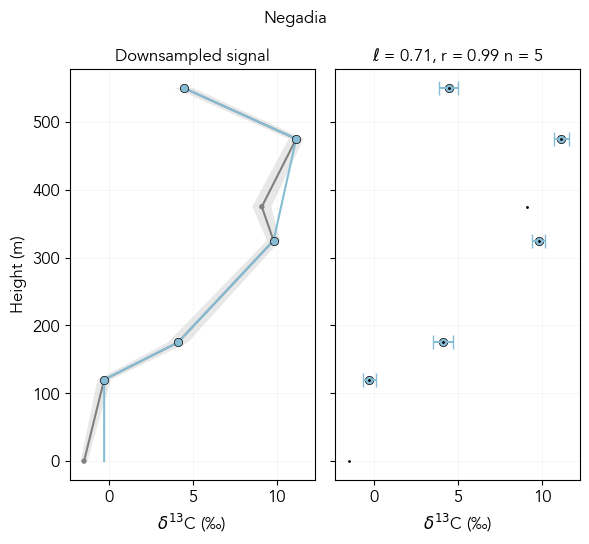

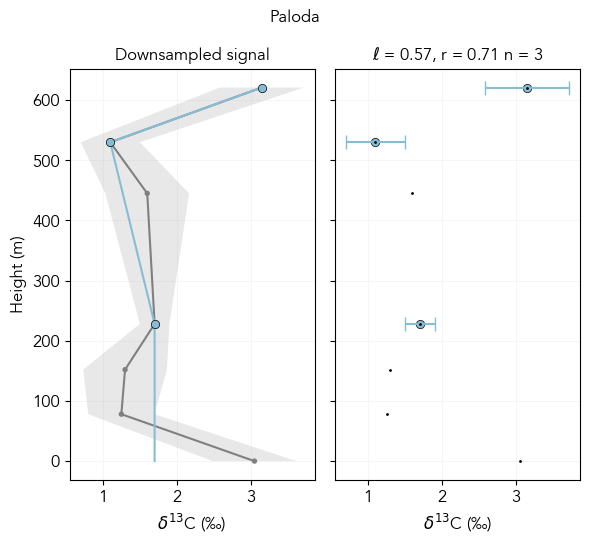

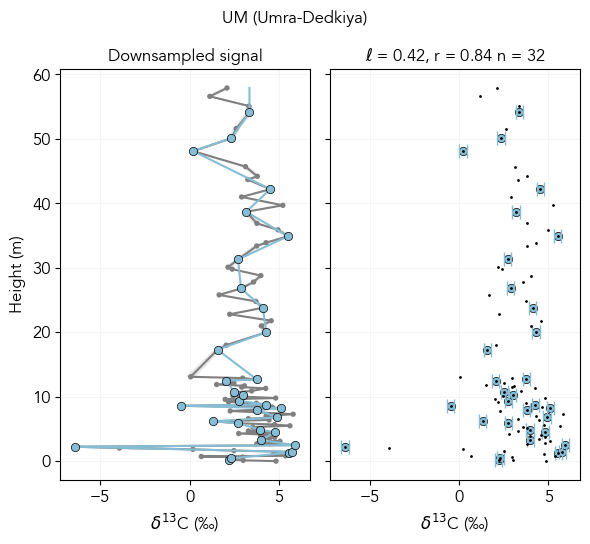

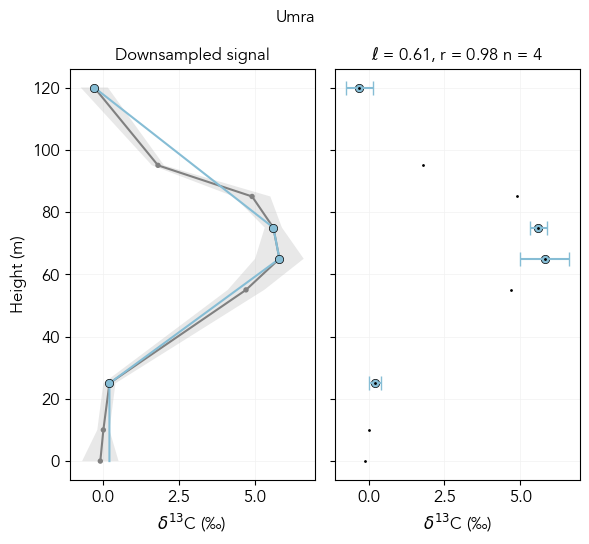

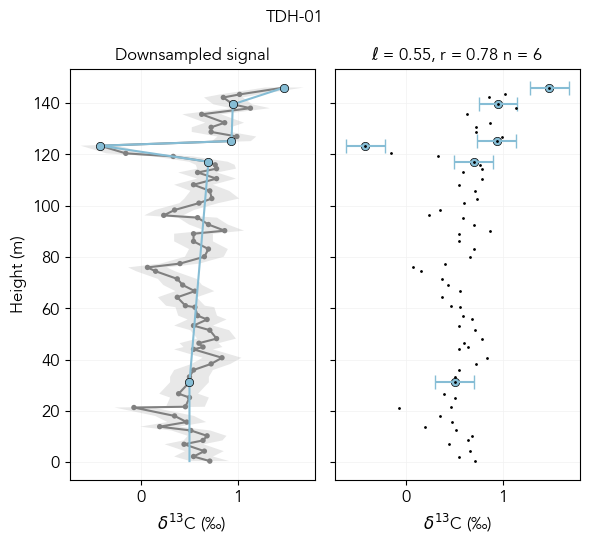

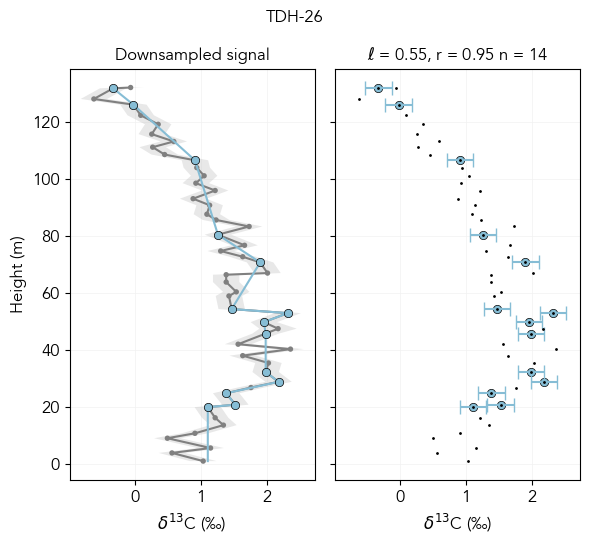

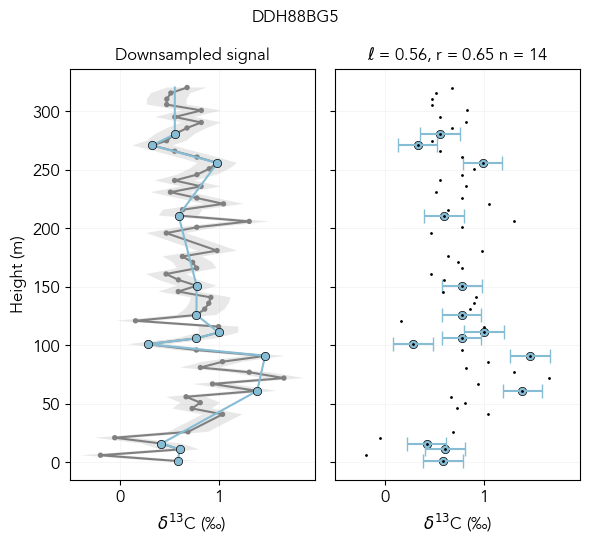

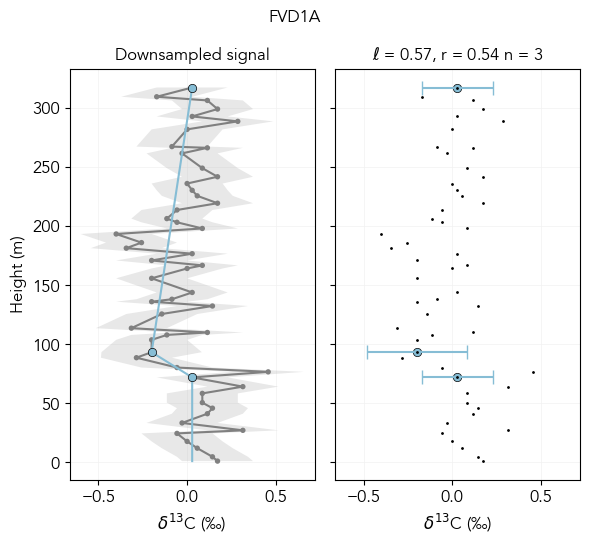

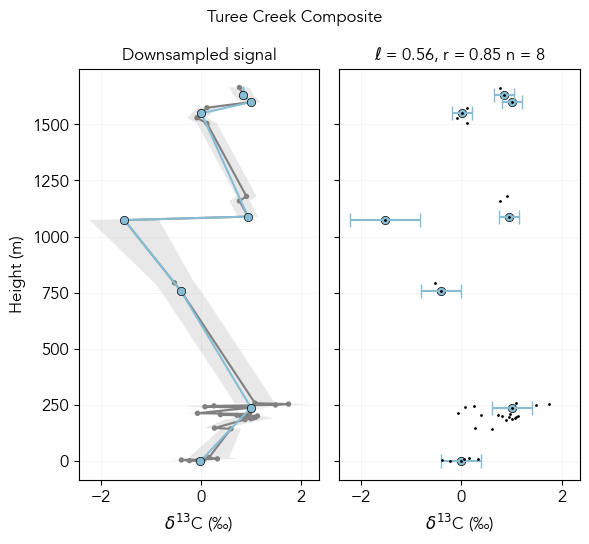

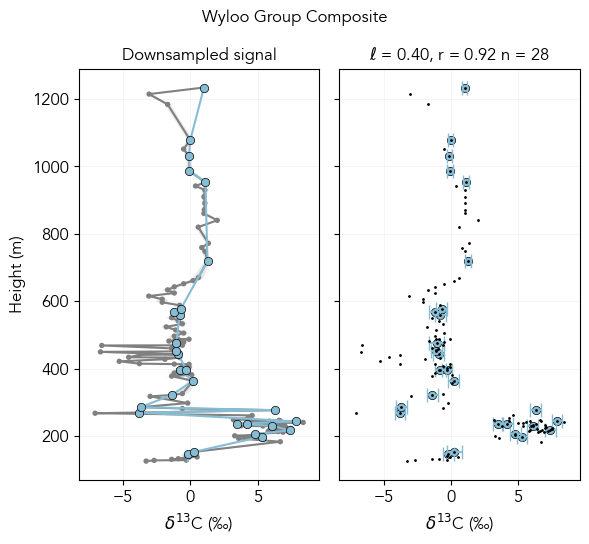

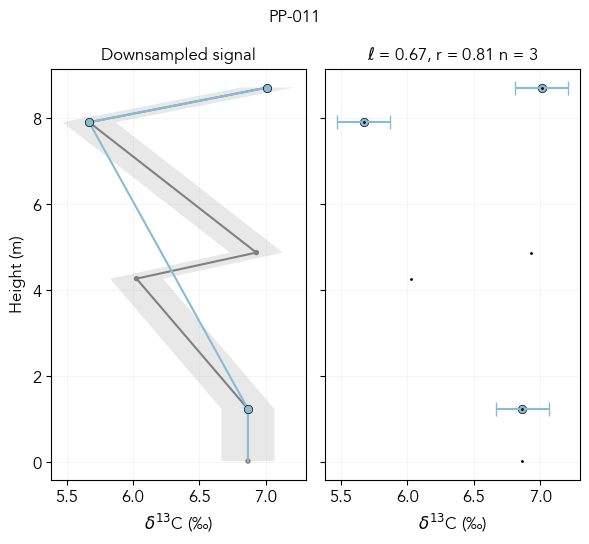

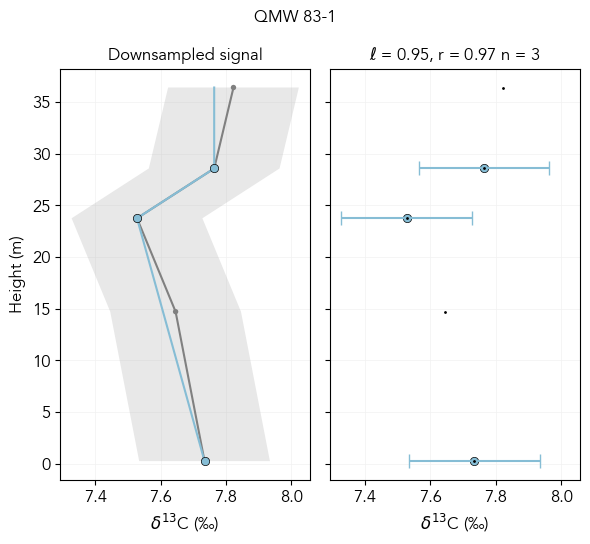

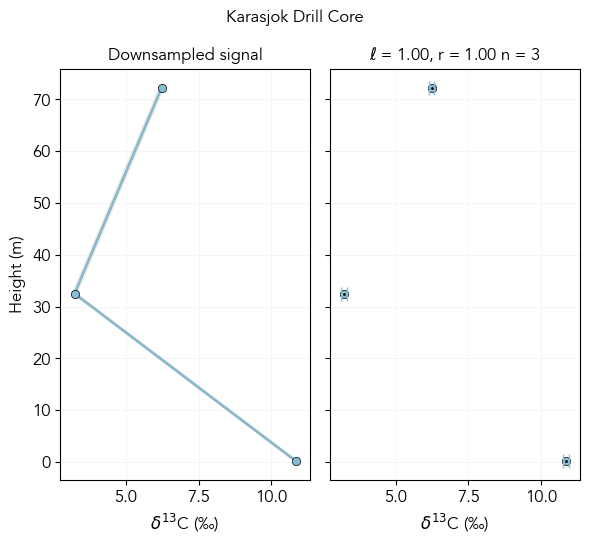

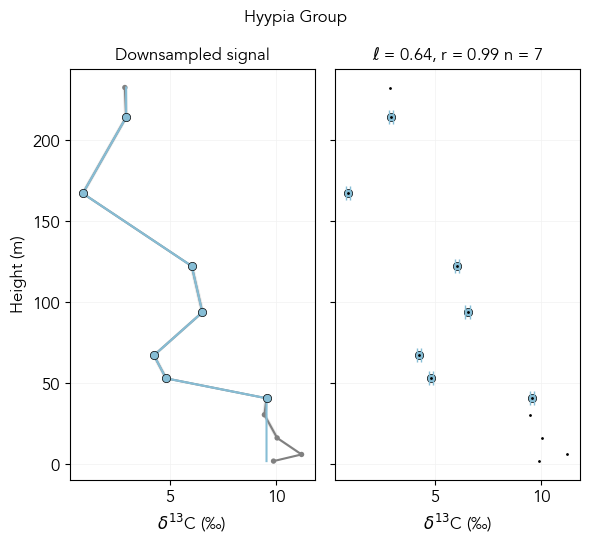

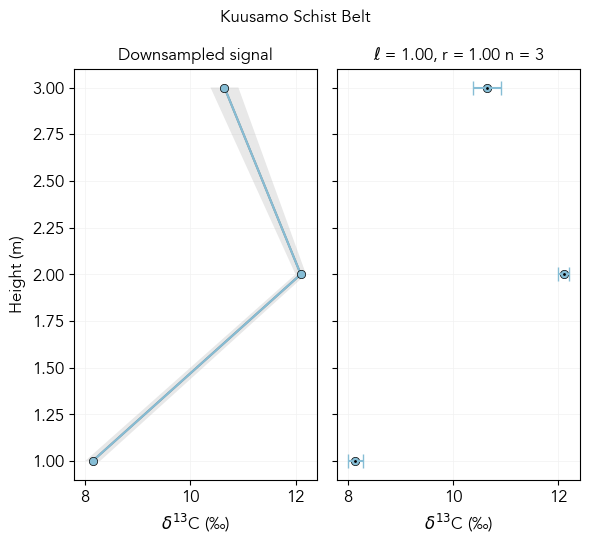

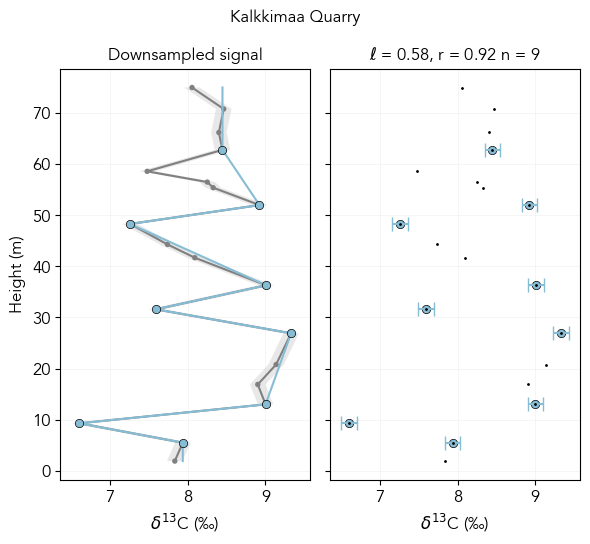

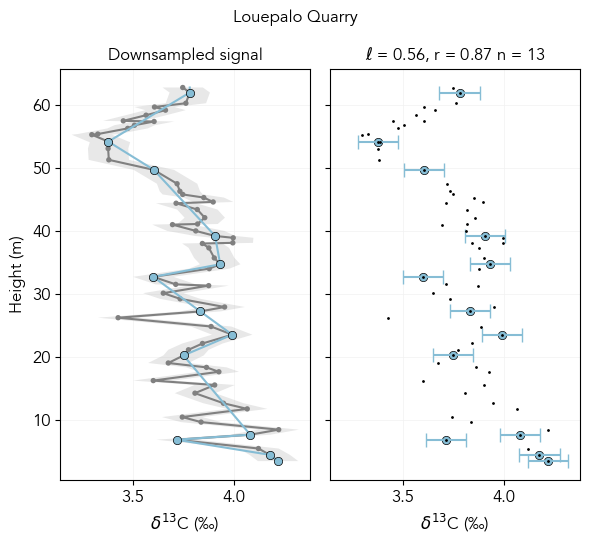

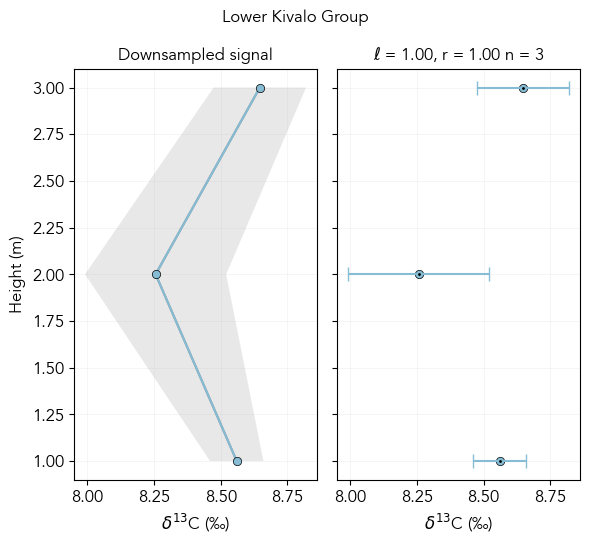

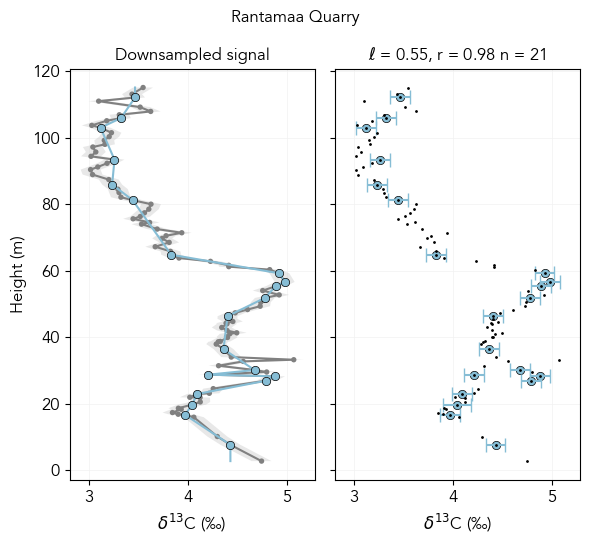

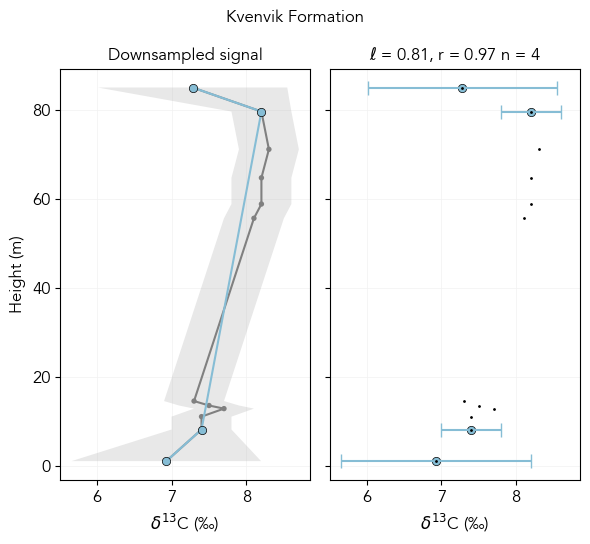

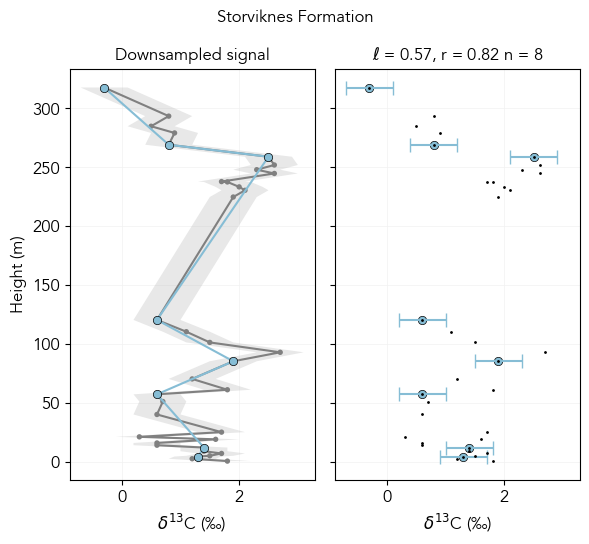

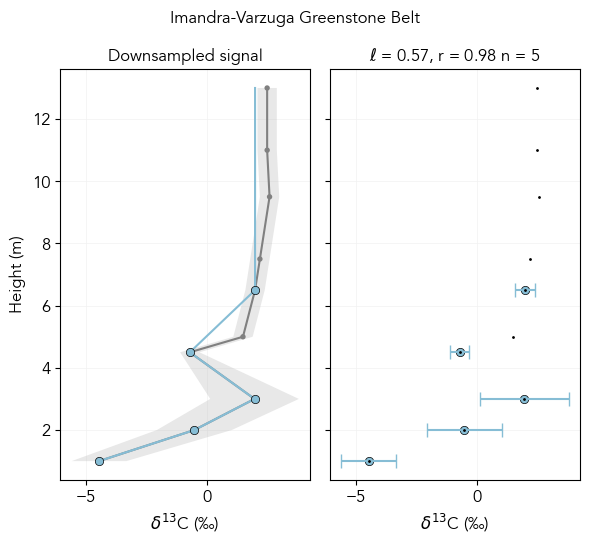

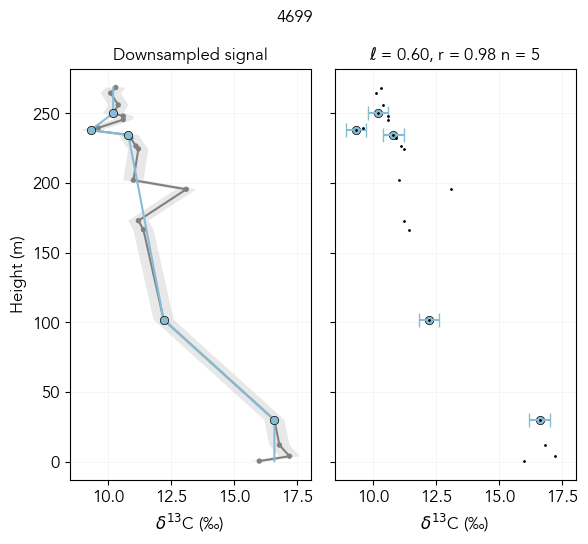

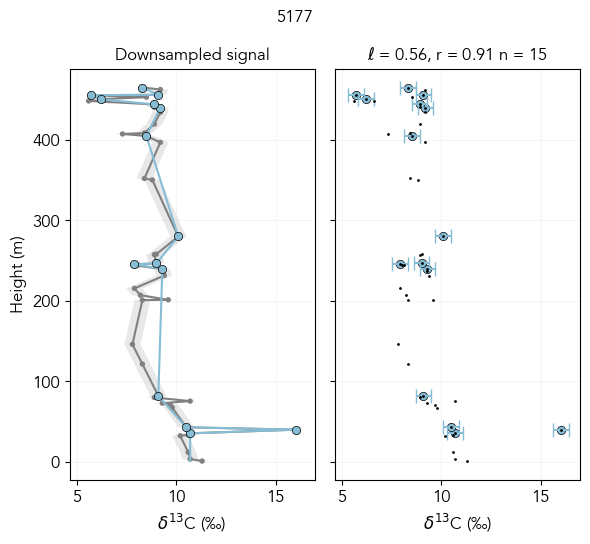

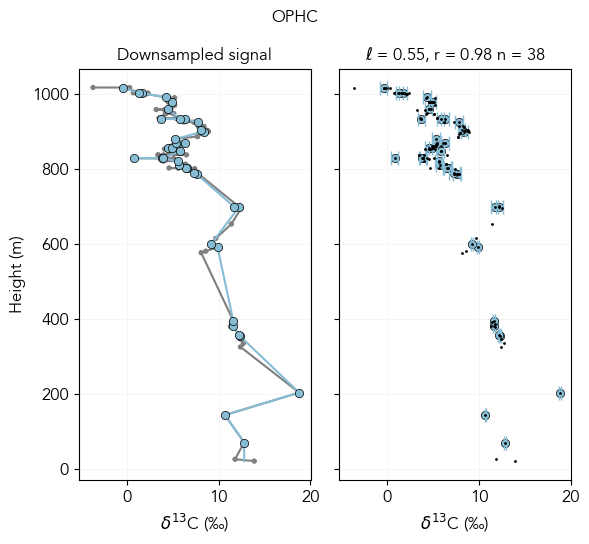

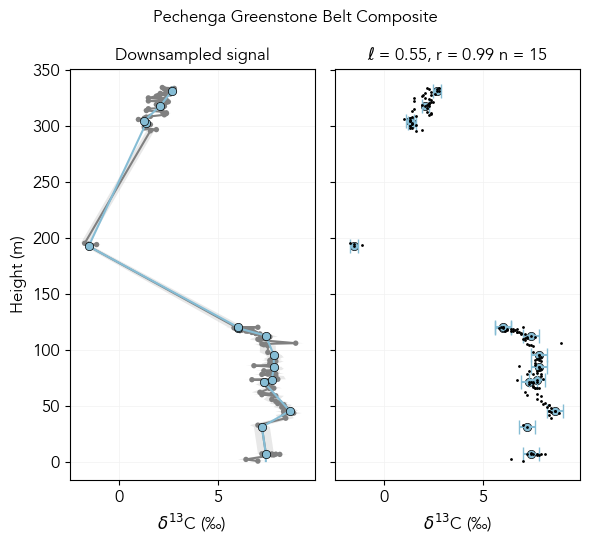

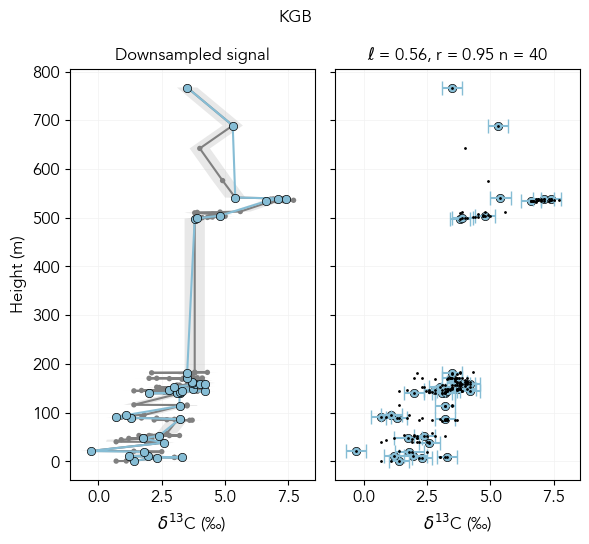

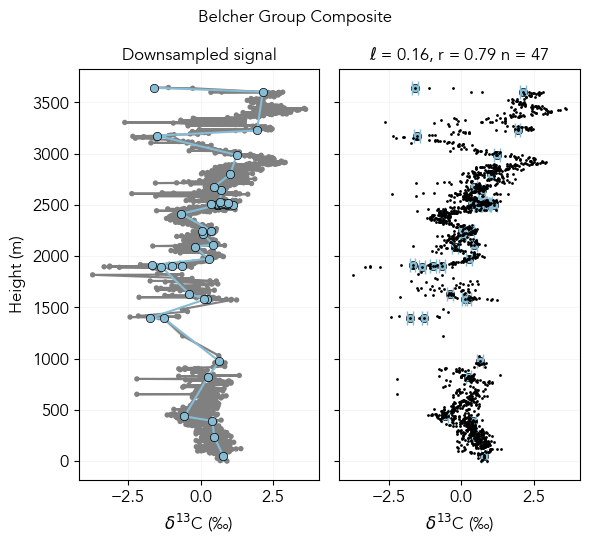

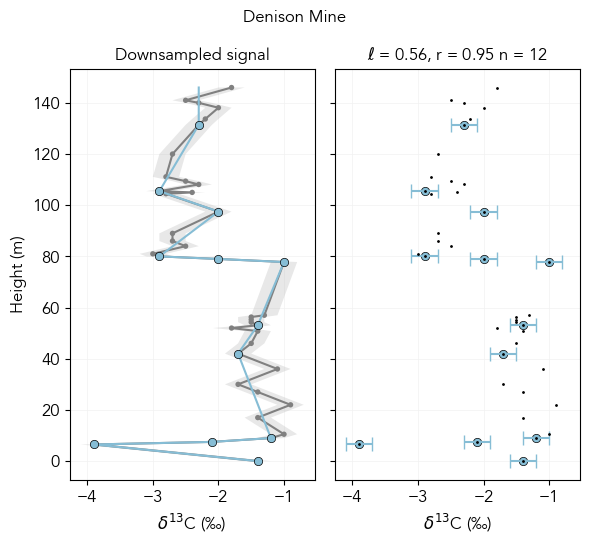

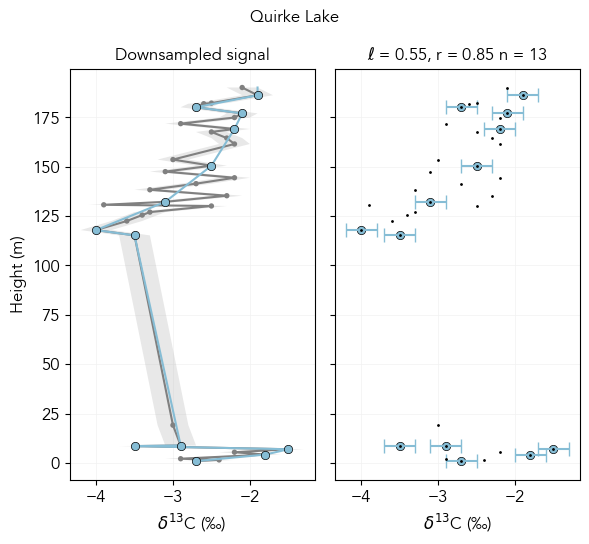

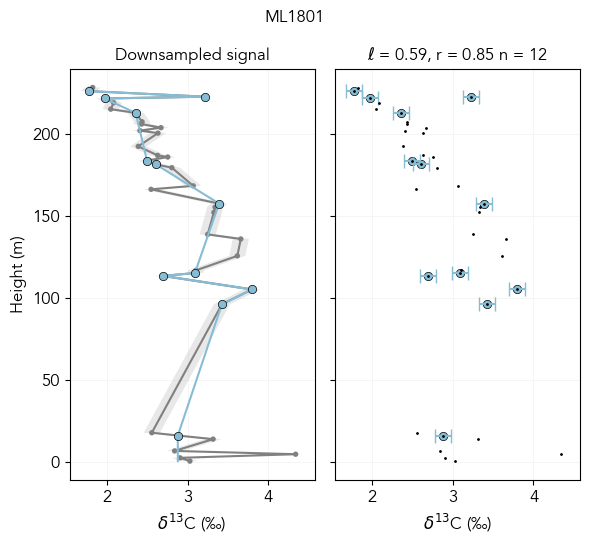

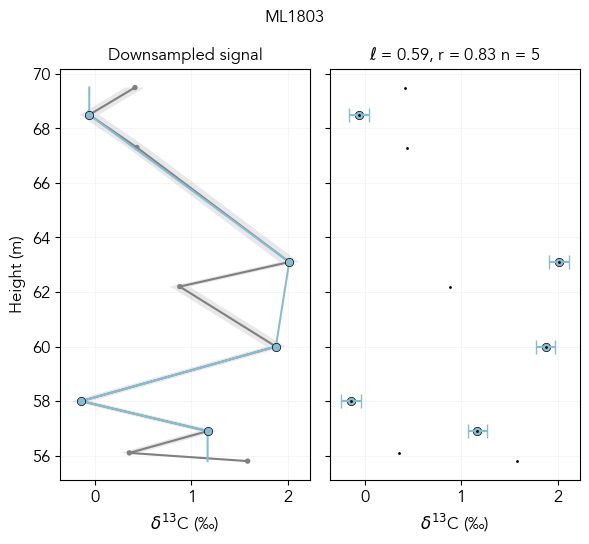

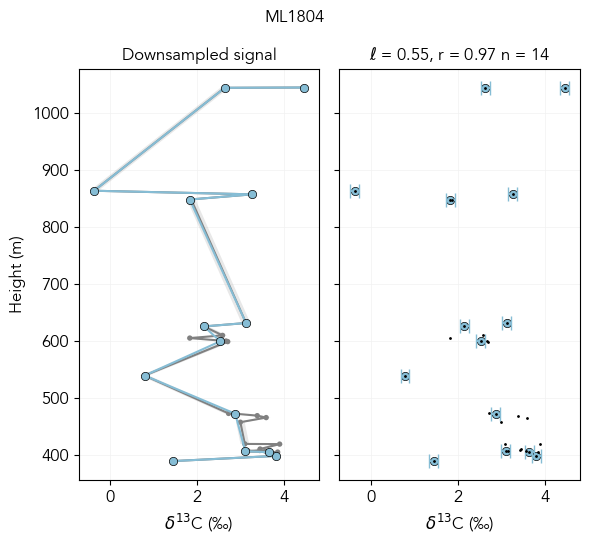

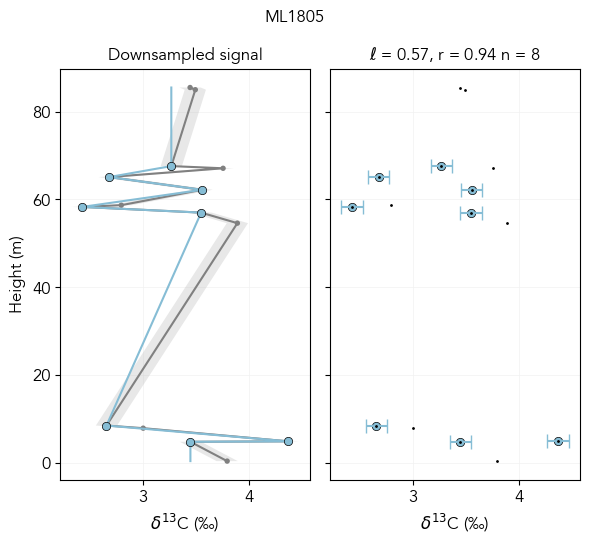

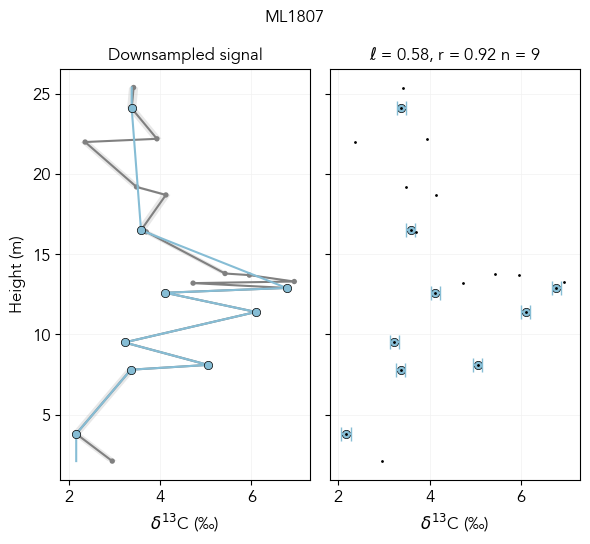

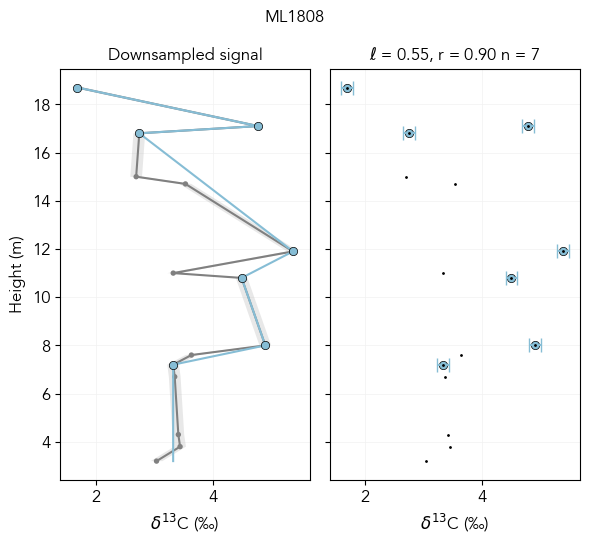

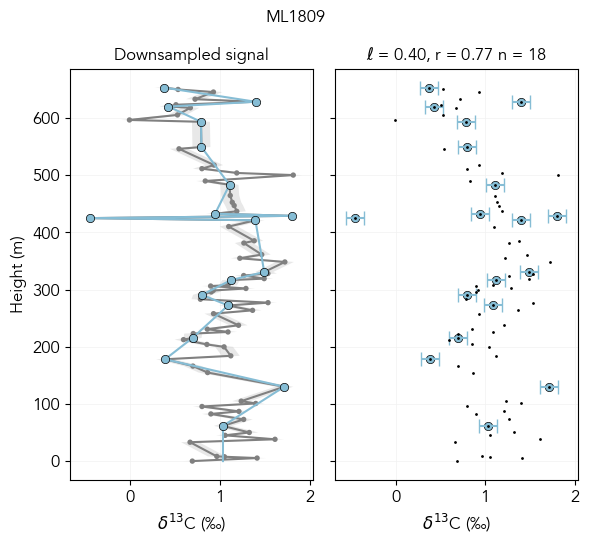

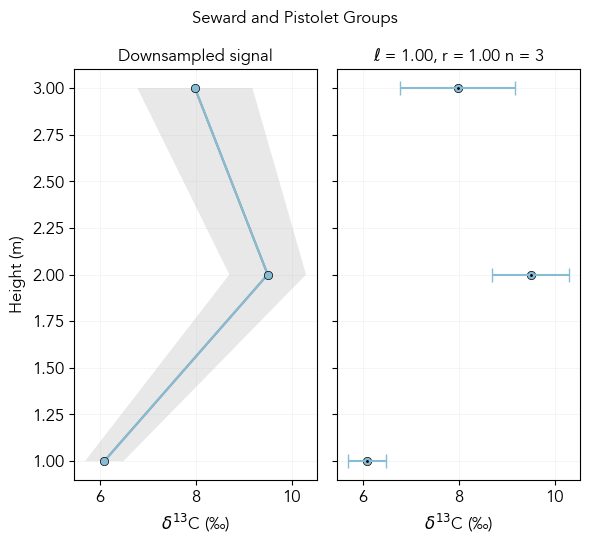

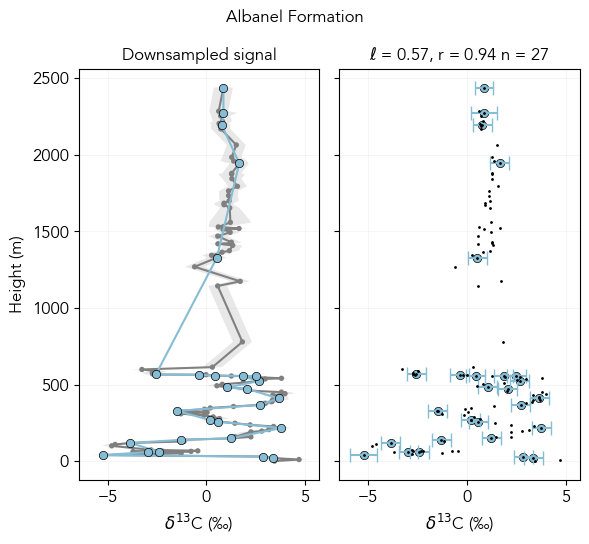

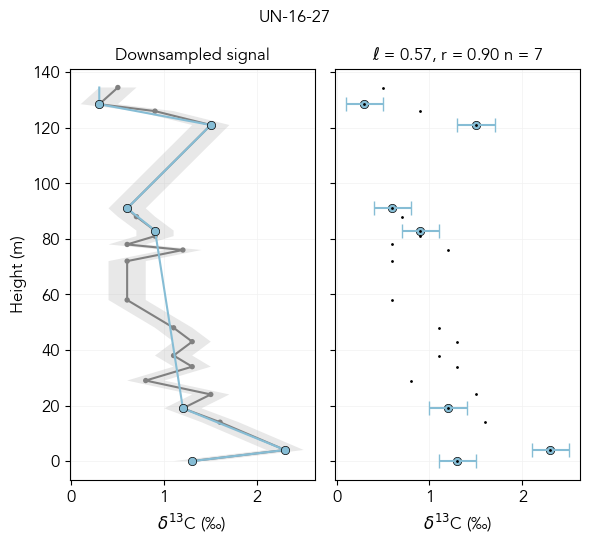

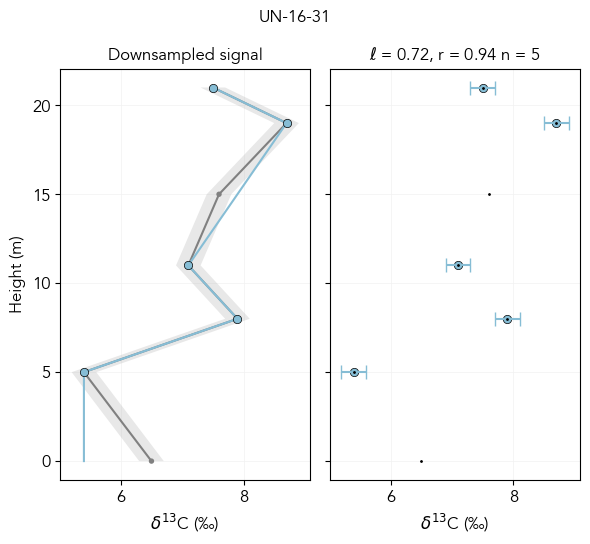

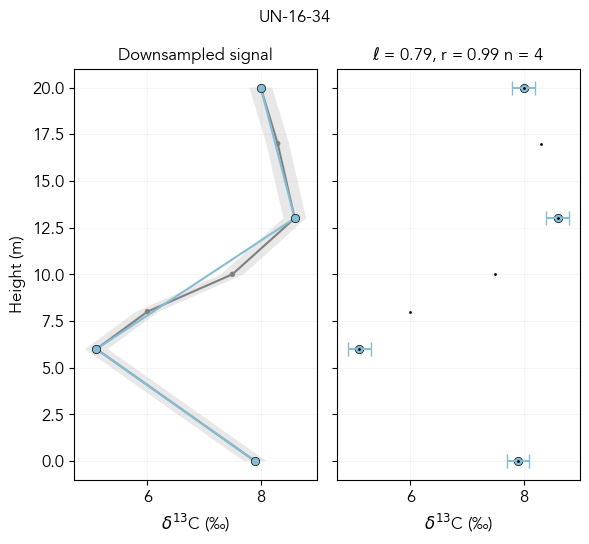

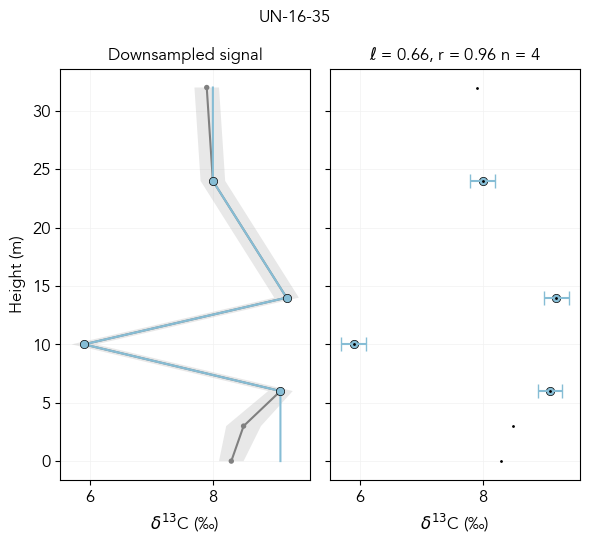

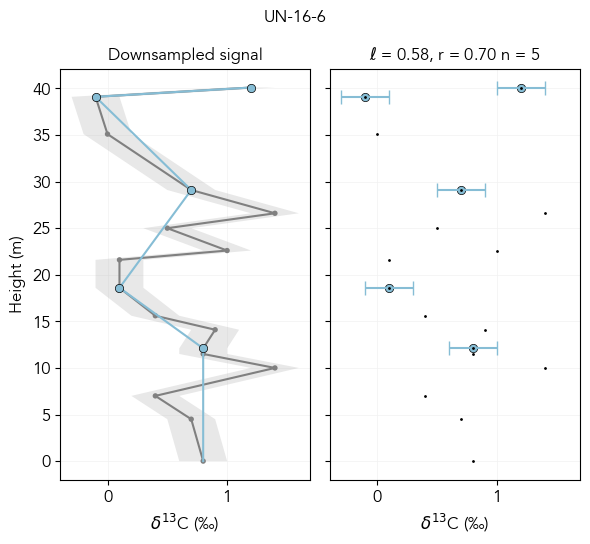

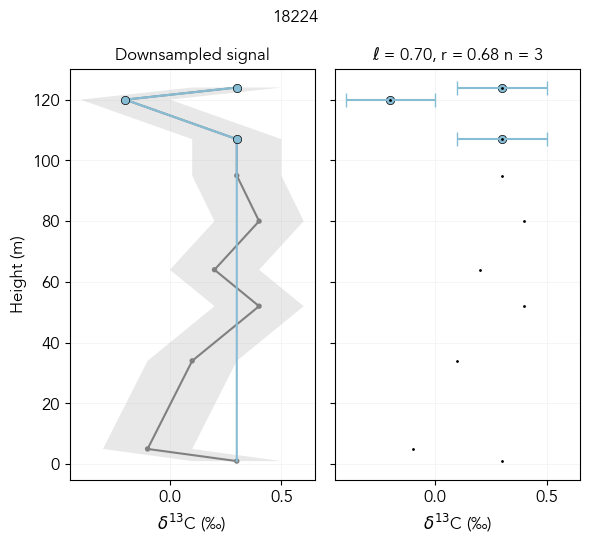

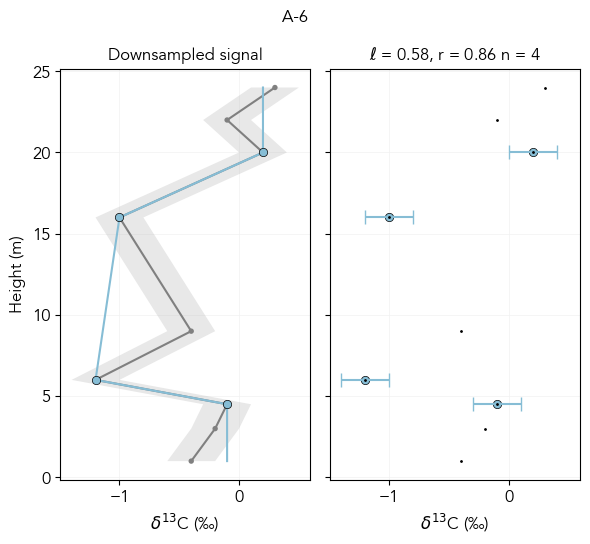

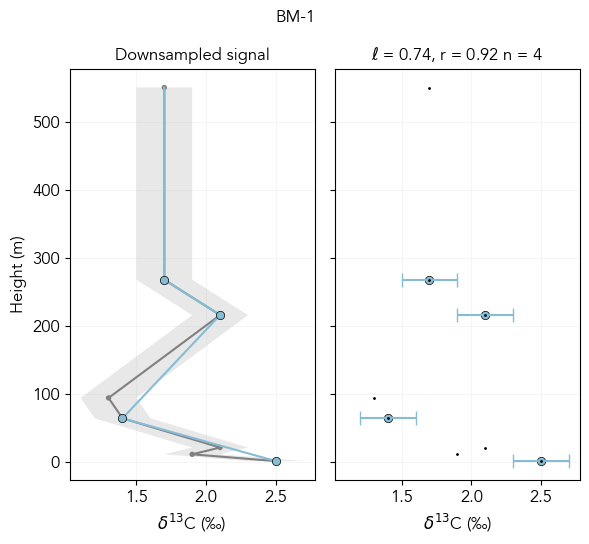

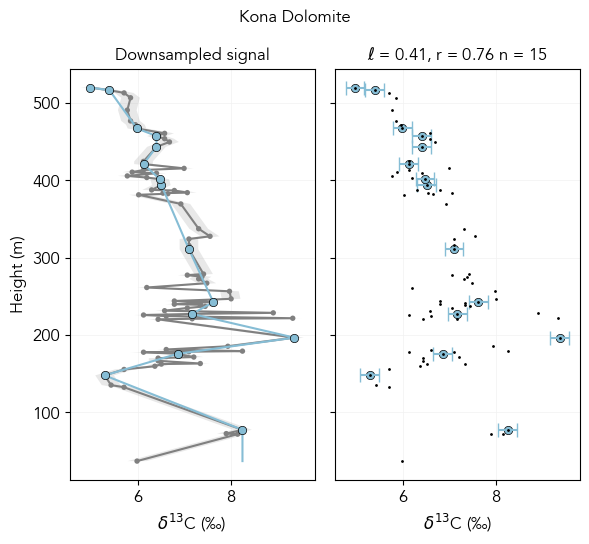

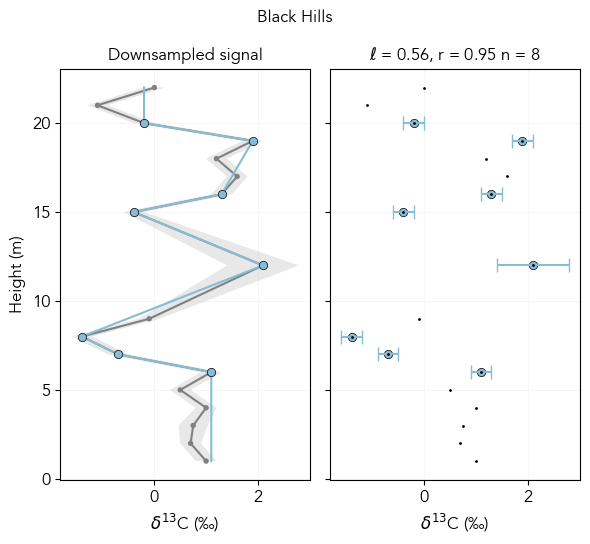

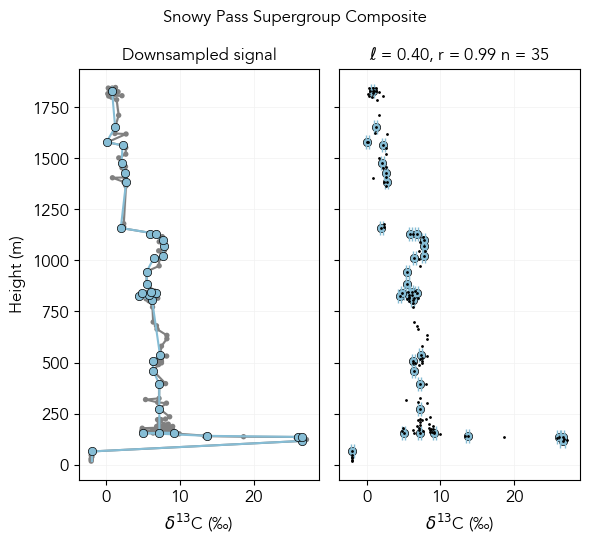

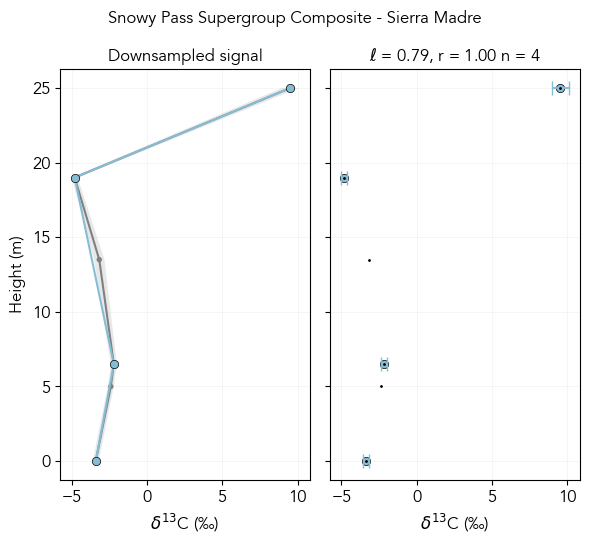

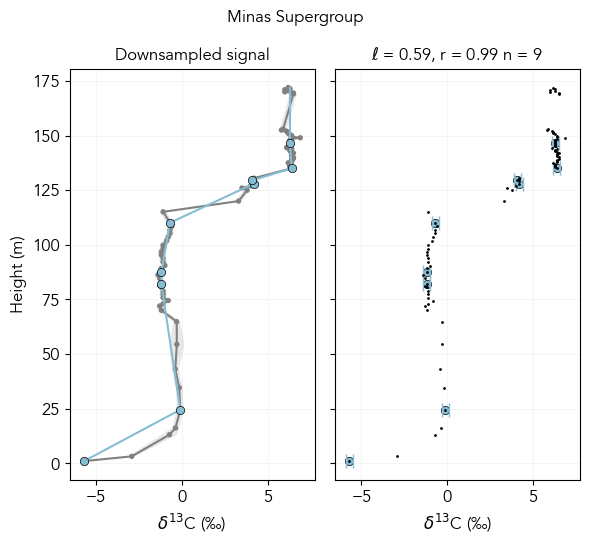

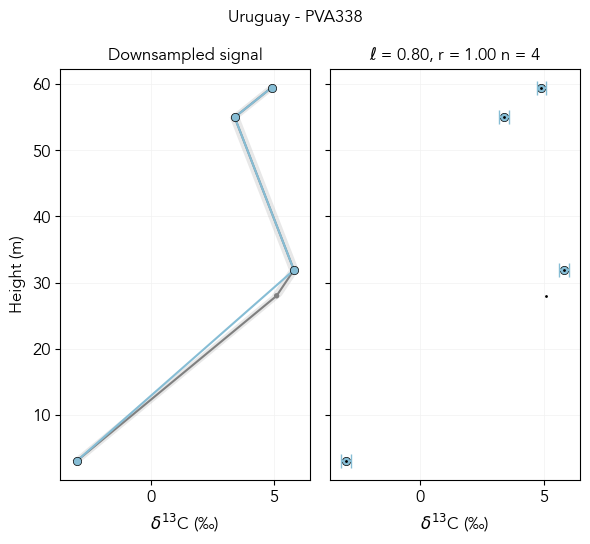

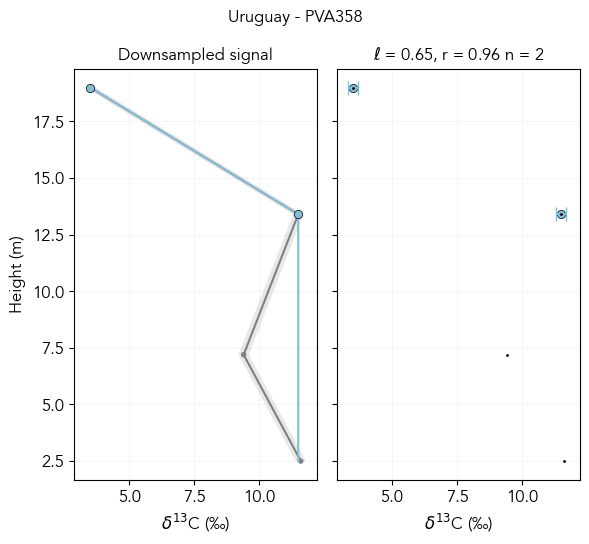

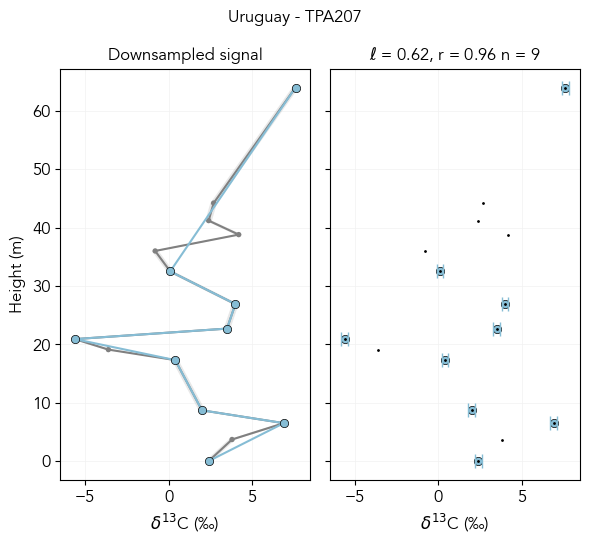

In [152]:
fs = 12
proxy = 'd13c'

for section in downsample_sections: 
    section_df = sample_df[(sample_df['section']==section) & (~sample_df['Exclude?'].astype(bool))].dropna(subset = proxy)
    height_grid = section_df['height'].values
    proxy_grid = section_df[proxy].values
    proxy_std_vec = section_df[proxy + '_std'].values

    mean_proxy_std = np.mean(proxy_std_vec)

    interp_proxy = np.interp(height_grid, 
                             sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['height'], 
                             sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['d13c'])

    fig, ax = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (6, 5.5))

    # plot the full-resolution (original) signal with 2-sigma uncertainty on each data point
    ax[0].fill_betweenx(height_grid,
                        proxy_grid - 2 * proxy_std_vec,
                        proxy_grid + 2 * proxy_std_vec,
                        color=(.7,.7,.7), # '#86bdd5',
                        label=r'$2\sigma$ envelope (data)',
                        alpha = 0.3,
                        lw = 1.5,
                        edgecolor = 'none',
                        zorder = 1)

    # plot the subsampled signal
    ax[0].plot(interp_proxy, 
                height_grid, 
                label = 'Subsampled signal', 
                color = '#86bdd5', 
                zorder = 4)
    
    # plot the subsampled observations
    ax[0].scatter(sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['d13c'], 
                    sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['height'],
                    label = 'Subsampled data', 
                    color = '#86bdd5', 
                    edgecolor = 'k', 
                    lw = 0.5, 
                    zorder = 5)

    # plot the original signal
    ax[0].plot(proxy_grid, 
             height_grid, 
             label = 'Original signal', 
             color = 'gray',
             zorder = 2)

    # plot the original observations
    ax[0].scatter(sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['d13c'],
                    sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['height'],  
                    label = 'Original data', 
                    color = 'gray', 
                    s = 15,
                    edgecolor = 'none',
                    zorder = 3)


    ax[0].set_title(f'Downsampled signal')
    ax[1].set_title(fr'$\ell$ = {solution_likelihoods[section]:.2f}, r = {solution_corr_coef[section]:.2f} n = {len(sample_df_downsampled[(sample_df_downsampled['section'] == section) & (~sample_df_downsampled['Exclude?']) & ~(np.isnan(sample_df_downsampled[proxy]))][proxy])}')

    # plot the subsampled data with uncertainty
    ax[1].scatter(sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?'])]['d13c'], 
                    sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?'])]['height'], 
                    color = '#86bdd5',  
                    edgecolor = 'k',
                    zorder = 1,
                    lw = 0.5
                    )

    ax[1].errorbar(sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?'])]['d13c'], 
                    sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?'])]['height'],
                    xerr = 2 * sample_df_downsampled[(sample_df_downsampled['section'] == section) & (~sample_df_downsampled['Exclude?'])]['d13c_std'],
                    ecolor = '#86bdd5', 
                    linestyle = 'none', 
                    capsize = 5,
                    zorder = 2
                    )

    # plot the original observations
    ax[1].scatter(sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['d13c'], 
                    sample_df[(sample_df['section'] == section)& ~(sample_df['Exclude?'])]['height'], 
                    color = 'k', 
                    s = 1, 
                    zorder = 3
                    )

    for axis in ax.ravel(): 
        axis.set_xlabel(r'$\delta^{13}$C (‰)', fontsize = fs)
        axis.tick_params(labelsize = fs)
        axis.grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -1)
        axis.set_axisbelow(True)

    ax[0].set_ylabel('Height (m)', fontsize = fs)

    fig.suptitle(section)

    fig.tight_layout()

    plt.show()

    plt.close() 

## Supplementary Figure S2 (Data subsampling methods)

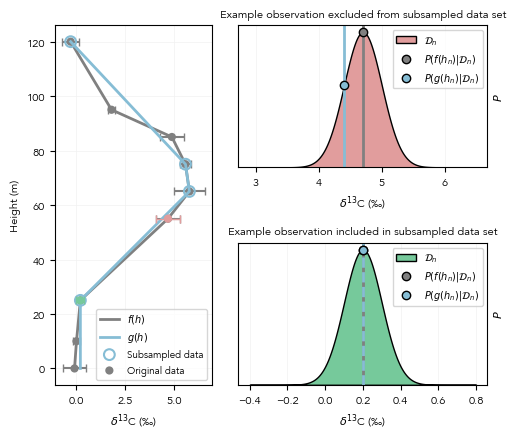

In [5]:
from scipy.stats import norm 

section = 'Umra' # example section through the Jhamarkotra Formation, India

height_grid = sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?']) & ~(np.isnan(sample_df['d13c']))]['height'].values
proxy_obs = sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?']) & ~(np.isnan(sample_df['d13c']))]['d13c'].values
proxy_std = sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?']) & ~(np.isnan(sample_df['d13c']))]['d13c_std'].values

mosaic = """
    11222
    11333
    """

fs = 8
fig, ax = plt.subplot_mosaic(mosaic,  figsize = (5.25, 4.5), sharex = False, sharey = False, constrained_layout = False)

# interpolate the subsampled signal to the original heights
proxy_interp = np.interp(height_grid, 
                             sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['height'], 
                             sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['d13c'])

# plot the original data
ax['1'].plot(proxy_obs, 
            height_grid, 
            label = '$f(h)$', 
            color = 'gray',
            lw = 2,
            zorder = 2)

# plot the (interpolated) subsampled signal
ax['1'].plot(proxy_interp, 
            height_grid, 
            label = '$g(h)$', #  (subsampled signal)
            color = '#86bdd5',
            lw = 2,
            zorder = 4)

# plot the subsampled observations
ax['1'].scatter(sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['d13c'], 
                sample_df_downsampled[(sample_df_downsampled['section'] == section) & ~(sample_df_downsampled['Exclude?']) & ~np.isnan(sample_df_downsampled['d13c'])]['height'],
                label = 'Subsampled data', 
                edgecolor = '#86bdd5', 
                color = 'none',
                lw = 1.5, 
                s = 60, 
                zorder = 5)

# plot the original observations with 2-sigma measurement uncertainty
ax['1'].scatter(sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['d13c'],
                sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['height'],  
                label = 'Original data', 
                color = 'gray', 
                s = 35,
                edgecolor = 'none',
                zorder = 3)

ax['1'].errorbar(sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['d13c'],
                sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['height'],  
                xerr = 2 * sample_df[(sample_df['section'] == section) & ~(sample_df['Exclude?'])]['d13c_std'],  
                capsize = 3,
                color = 'gray', 
                linestyle = 'none',
                zorder = 2)

ax['1'].set_ylabel('Height (m)', fontsize = fs)
ax['1'].legend(fontsize = fs - 1, loc = 4)

## lower example - data point kept 
sample = 2

# plot in green on stratigraphy panel
ax['1'].scatter(proxy_obs[sample], 
                height_grid[sample],
                edgecolor = 'none', 
                color = '#76C99B',
                lw = 1, 
                s = 35, 
                zorder = 7)

ax['1'].errorbar(proxy_obs[sample], 
                height_grid[sample],
                xerr = 2 * proxy_std[sample], 
                linestyle = 'none',
                color = '#76C99B',
                capsize = 3, 
                lw = 1, 
                zorder = 6)

# evaluate the probability density (conditioned on the observation) of the original and subsampled/interpolated signals
original_signal_prob = norm.pdf(proxy_obs[sample], proxy_obs[sample], proxy_std[sample]) 

interp_signal_prob = norm.pdf(proxy_interp[sample], proxy_obs[sample], proxy_std[sample]) 

xs = np.linspace(proxy_obs[sample] - proxy_std[sample] * 6, proxy_obs[sample] + proxy_std[sample] * 6, 1000)
sample_pdf = norm.pdf(xs, proxy_obs[sample], proxy_std[sample])

# plot the PDF of the observation, with vertical lines corresponding to the original and subsampled signals
ax['3'].fill_between(xs, sample_pdf, color = '#76C99B', edgecolor = 'k', lw = 1, label = r'$\mathcal{D}_n$')
ax['3'].axvline(proxy_obs[sample], color = 'gray', linestyle = 'solid', lw = 2)
ax['3'].axvline(proxy_interp[sample], color = '#86bdd5', linestyle = 'dashed', lw = 2)
ax['3'].axvline(proxy_interp[sample], color = '#86bdd5', linestyle = 'solid', lw = 2, zorder = -1)

ax['3'].scatter(proxy_obs[sample], original_signal_prob, color = 'gray', edgecolor = 'k', lw = 1, zorder = 5, label = r'$P(f(h_n)|\mathcal{D}_n)$')

ax['3'].scatter(proxy_interp[sample], interp_signal_prob, color = '#86bdd5', edgecolor = 'k', lw = 1, zorder = 5, label = r'$P(g(h_n)|\mathcal{D}_n)$')
ax['3'].set_ylim([0, ax['3'].get_ylim()[1]])

## upper example - data point excluded 
sample = 3

# plot in red on stratigraphy panel
ax['1'].scatter(proxy_obs[sample], 
                height_grid[sample],
                edgecolor = 'none', 
                color = '#E19D9D',
                lw = 1, 
                s = 35, 
                zorder = 7)

ax['1'].errorbar(proxy_obs[sample], 
                height_grid[sample],
                xerr = 2 * proxy_std[sample], 
                linestyle = 'none',
                color = '#E19D9D',
                capsize = 3, 
                lw = 1, 
                zorder = 6)

# evaluate the probability density (conditioned on the observation) of the original and subsampled/interpolated signals
original_signal_prob = norm.pdf(proxy_obs[sample], proxy_obs[sample], proxy_std[sample]) 
interp_signal_prob = norm.pdf(proxy_interp[sample], proxy_obs[sample], proxy_std[sample]) 

xs = np.linspace(proxy_obs[sample] - proxy_std[sample] * 6, proxy_obs[sample] + proxy_std[sample] * 6, 1000)
sample_pdf = norm.pdf(xs, proxy_obs[sample], proxy_std[sample])

# plot the PDF of the observation, with vertical lines corresponding to the original and subsampled signals
ax['2'].fill_between(xs, sample_pdf, color = '#E19D9D', edgecolor = 'k', lw = 1, label = r'$\mathcal{D}_n$')
ax['2'].axvline(proxy_obs[sample], color = 'gray', linestyle = 'solid', lw = 2)
ax['2'].axvline(proxy_interp[sample], color = '#86bdd5', linestyle = 'solid', lw = 2)
ax['2'].scatter(proxy_obs[sample], original_signal_prob, color = 'gray', edgecolor = 'k', lw = 1, zorder = 5, label = r'$P(f(h_n)|\mathcal{D}_n)$')
ax['2'].scatter(proxy_interp[sample], interp_signal_prob, color = '#86bdd5', edgecolor = 'k', lw = 1, zorder = 5, label = r'$P(g(h_n)|\mathcal{D}_n)$')

for key in ['2', '3']:
    ax[key].set_ylim([0, ax[key].get_ylim()[1]])
    ax[key].set_yticks([])
    ax[key].yaxis.set_label_position("right")
    ax[key].set_ylabel('$P$', fontsize = fs) 
    
for key in ['1', '2', '3']:   
    ax[key].set_xlabel(r'$\delta^{13}$C (‰)', fontsize = fs)
    ax[key].tick_params(labelsize = fs)
    ax[key].set_axisbelow(True)
    ax[key].grid(color=(0.95, 0.95, 0.95), linewidth=0.5, linestyle = 'solid', zorder = -10)
    
    
ax['2'].legend(fontsize = fs - 1)
ax['3'].legend(fontsize = fs - 1)

ax['2'].set_title('Example observation excluded from subsampled data set', fontsize = fs)
ax['3'].set_title('Example observation included in subsampled data set', fontsize = fs)

fig.tight_layout()
fig.subplots_adjust(wspace = 0.4)


path = 'FigS2'
fig.savefig(str("figures/"+ path +".pdf"), format="pdf", facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.1)


## Summary statistics
Sample counts by priority level; samples from priority levels 1 and 2 are included in the Paleoproterozoic d13C inference model

In [6]:

priority_1_2_downsampled_count = 0
priority_1_downsampled_count = 0
priority_1_count = 0
priority_1_2_count = 0

for section in priority_1_sections: 
    priority_1_count += sample_df[(sample_df['section'] == section) & (~np.isnan(sample_df['d13c'])) & (~sample_df['Exclude?'])].shape[0]

    priority_1_downsampled_count += sample_df_downsampled[(sample_df_downsampled['section'] == section) & (~np.isnan(sample_df_downsampled['d13c'])) & (~sample_df_downsampled['Exclude?'])].shape[0]

for section in include_sections: 

    priority_1_2_count += sample_df[(sample_df['section'] == section) & (~np.isnan(sample_df['d13c'])) & (~sample_df['Exclude?'])].shape[0]

    priority_1_2_downsampled_count += sample_df_downsampled[(sample_df_downsampled['section'] == section) & (~np.isnan(sample_df_downsampled['d13c'])) & (~sample_df_downsampled['Exclude?'])].shape[0]

print(f'Sample counts after subsampling:')
print(f'Priority 1 (original): {priority_1_count}')
print(f'Priority 1 + Priority 2 (original): {priority_1_2_count}')
print(f'Priority 1 (subsampled): {priority_1_downsampled_count}')
print(f'Priority 1 + Priority 2 (subsampled): {priority_1_2_downsampled_count}')

Sample counts after subsampling:
Priority 1 (original): 2853
Priority 1 + Priority 2 (original): 4640
Priority 1 (subsampled): 729
Priority 1 + Priority 2 (subsampled): 849
